In [1]:
# Data Preprocessing
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from scipy.stats.mstats import winsorize
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt

# Read the input file
dataset = pd.read_csv('BovespaDeepLearning.csv', sep=';')
dataset = dataset[['TICKER', 'Data', 'DATA_REGISTRO',
       'SETOR', 'CRESC_LL_12M','CRESC_RL_12M', 'DY_12M', 'ROIC', 'ROA', 'ROE', 'Margem_Operacional',
       'Margem_Liquida', 'Margem_Bruta', 'PSR', 'PVPA', 'IPL', 'PEG', 'LPA', 'FREEFLOAT', 'PL', 'CE', 'LG',
       'CCL', 'LC', 'LI', 'LS', 'G', 'ICP', 'AT', 'MARKET_VALUE', 'AC', 'PC',
       'MARKET_VALUE_AT', 'RLP_AT', 'ELP_AT', 'IMOBILIZADO_AT',
       'CONTAS_A_RECEBER_CP_AT', 'LOP_GER_AT', 'LUCRO_PREJ_ACUM_AT', 'DIVIDA_BRUTA_AT',
       'DIVIDA_LIQUIDA_AT', 'DESPESAS_RECEITAS_OPERACIONAIS_AT', 'CCL_AT', 'Rent_1a']]

#Remove lines with nulls for the main indexes
dataset = dataset[dataset['IPL'].notnull()]
dataset = dataset[dataset['PVPA'].notnull()]
dataset = dataset[dataset['AT'].notnull()]
dataset = dataset[dataset['SETOR'].notnull()]
dataset = dataset[dataset['LUCRO_PREJ_ACUM_AT'].notnull()]
dataset['Ticker_ID'] = LabelEncoder().fit_transform(dataset['TICKER'])

Using TensorFlow backend.


In [2]:
#For the case the mean of the ticker is equal to zero
#We will fill the null values equals to the mean of the column
dataset = dataset.fillna(dataset.mean())
#dataset.info()

In [3]:
numerical=dataset.select_dtypes(include=[np.number]).columns.tolist()
#dataset[numerical].hist(bins=20, figsize=(20, 20))
#plt.title('Histograms')

In [4]:
### CLEANING DATA

# Winsorization approach to handle extreme values in the limit
a = 0
for i in numerical:
    #Remove from the winsorization the y variables and histograms that seems ok
    if numerical[a] not in ['Rent_1a','FREEFLOAT','CE'] : 
        Win = winsorize( dataset[numerical[a]],limits = [0.01,0.01])
        dataset[numerical[a]] = Win
    a = a + 1
    
dataset['Ano'] = dataset['Data'].astype(str).str[:4]
dataset['Mes'] = dataset['Data'].astype(str).str[6:7]
dataset = dataset[dataset['Mes'] == '6']

In [5]:
a = dataset[dataset['Ano'] !='2019']['Rent_1a']
a[a <= 4.45].count()

898

In [6]:
a[a > 4.45].count()

898

In [7]:
#dataset[numerical].hist(bins=20, figsize=(20, 20))
#plt.title('Histograms')

In [8]:
dataset['Rentability_1a'] = dataset['Rent_1a']

# Set target rentability %
buy = 4.45

def f(row):
    if row['Rent_1a'] > buy:
        val = 1
    else:
        val = 0
    return val
dataset['Rent_1a'] = dataset.apply(f, axis=1)

In [9]:
# Here we ignore the first 3 (non-predictive features)
X = dataset.iloc[:, 3:49]
# y is a vector containing the information about the target
y = dataset.iloc[:, 43:48].values

In [10]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['SETOR']),
    remainder='passthrough')
X = column_trans.fit_transform(X)

In [11]:
#Xf = X[X[:,58]=='2019']
Xa = X[X[:,58]!='2019']

#yf = y[y[:,2]=='2019']
ya = y[y[:,2]!='2019']

In [12]:
# Creation of training and test sets
from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(Xa, ya, test_size = 0.5, random_state=1)

In [13]:
y_train = y_train_c[:,0].astype(str).astype('int64')
y_test = y_test_c[:,0].astype(str).astype('int64')
#yf = yf[:,0].astype(str).astype(int)
X_train = X_train_c[:,:56]
X_test = X_test_c[:,:56]
#Xf = Xf[:,:56]

In [14]:
# Preprocessing: feature normalization
#mean = X_train.mean(axis=0)
#X_train -= mean
#std = X_train.std(axis=0)
#X_train /= std

#X_test -= mean
#X_test /= std


# Preprocessing: feature Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Standardization only uses the information on the training set!!!
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#Xf = sc.transform(Xf)

In [15]:
# Creation of the model

def build_model():
    # Creation of an empty model
    model = Sequential()

    # Adding the input layer and the first hidden layer
    model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 56))

    # Adding the second hidden layer
    model.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu'))
    
    # Adding the second hidden layer
    model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    # Adding the output layer
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [16]:
# 5-fold Cross Validation 
all_acc_histories = []
all_val_acc_histories = []
all_loss_histories = []
all_val_loss_histories = []

k = 5
num_val_samples = len(X_train) // k
num_epochs = 15
all_scores = []


for i in range(k):
    print(f'Processing fold # {i}')
    val_data = X_train[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
                            [X_train[:i * num_val_samples],
                            X_train[(i+1) * num_val_samples:]],
                            axis=0)
    partial_train_targets = np.concatenate(
                            [y_train[:i * num_val_samples],
                            y_train[(i+1)*num_val_samples:]],
                            axis=0)
    model = build_model()
    
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs,
                       )
    val_mse, val_acc = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_acc)
    
    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_acc_history)
    all_loss_histories.append(loss_history)
    all_val_loss_histories.append(val_loss_history)

	
# Here we print the scores
print(f'all_scores : {all_scores}')
print(f'mean all scores : {np.mean(all_scores)}')

Processing fold # 0
Train on 719 samples, validate on 179 samples
Epoch 1/15
719/719 [==============================] - 1s 1ms/step - loss: 0.6934 - accuracy: 0.4784 - val_loss: 0.6933 - val_accuracy: 0.4804
Epoch 2/15
719/719 [==============================] - 0s 78us/step - loss: 0.6931 - accuracy: 0.5090 - val_loss: 0.6933 - val_accuracy: 0.4804
Epoch 3/15
719/719 [==============================] - 0s 78us/step - loss: 0.6930 - accuracy: 0.5090 - val_loss: 0.6934 - val_accuracy: 0.4804
Epoch 4/15
719/719 [==============================] - 0s 78us/step - loss: 0.6928 - accuracy: 0.5104 - val_loss: 0.6934 - val_accuracy: 0.4804
Epoch 5/15
719/719 [==============================] - 0s 100us/step - loss: 0.6923 - accuracy: 0.5229 - val_loss: 0.6932 - val_accuracy: 0.4916
Epoch 6/15
719/719 [==============================] - 0s 89us/step - loss: 0.6914 - accuracy: 0.5522 - val_loss: 0.6926 - val_accuracy: 0.5140
Epoch 7/15
719/719 [==============================] - 0s 67us/step - loss: 0

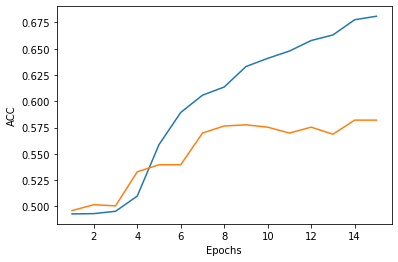

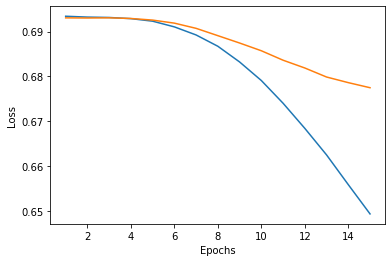

In [17]:
# Here we compute the history of successive mean K-fold validation scores
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.show()

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [18]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.50).astype(int)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Print Statistics from Confusion Matrix
from sklearn.metrics import classification_report
target_names = ['Do Nothing','Buy']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Do Nothing       0.58      0.54      0.56       452
         Buy       0.57      0.61      0.59       446

    accuracy                           0.57       898
   macro avg       0.57      0.57      0.57       898
weighted avg       0.57      0.57      0.57       898



In [19]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 419, 1: 479}

In [20]:
sum(y_test_c[:,4].astype(str).astype(float) * y_pred[:,0].astype(int))/(dict(zip(unique, counts))[1])

19.87774665588597

In [21]:
sum(y_test_c[:,4].astype(str).astype(float))/len(y_test)

13.344528607248854